In [201]:
import torch
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch
import re
import os
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score

In [196]:
sns.set_style("whitegrid")

In [17]:
!pip install -q -U bitsandbytes
!pip install -q -U accelerate
!pip install -q -U transformers

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Sun Feb 25 16:10:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                        Off| 00000000:5E:00.0 Off |                    0 |
| N/A   35C    P8                9W /  70W|      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load Data

In [4]:
BASE_DIR = Path('Mistral7B.ipynb').resolve().parent.parent
DATA_DIR = BASE_DIR.joinpath('matveeva/datasets')

FILE_NAME_QUAL = 'data_quality_estim_4classes.csv'

FILE_QUAL = DATA_DIR.joinpath(FILE_NAME_QUAL)

In [5]:
data_quality = pd.read_csv(FILE_QUAL)
data_quality.head(10)

,task,agg_label
0,able amaze fill glad stop daily fantastic move...,rather_bad
1,able amaze fill stop glad daily fantastic move...,rather_bad
2,able amaze fill stop glad daily fantastic move...,rather_bad
3,able amaze glad fill stop fantastic daily move...,bad
4,absolute church truth doug scripture symbol li...,rather_good
5,absolute church truth mission nasa doug mars e...,rather_bad
6,absolute mission church nasa mars earth truth ...,good
7,absolutely fast white rice service noodle terr...,rather_bad
8,absolutely fast white super service customer r...,good
9,absolutely grain experience soon there's proce...,bad


## Load Model

In [16]:
# model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
# tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

# Instruct-v0.2 Out of memory on inference Tesla T4
# model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
# tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

# Instruct-v0.2 4-bit quantization
# Qunatization config
quantization_config_4bit = BitsAndBytesConfig(
    load_in_4bit = True, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights //insert xzibit meme
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

# Load model
model_4bit = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.2",
    quantization_config=quantization_config_4bit,
)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Function Declarations

In [23]:
def generate_answer(prompt, model, device, temp, n_token):
    torch.cuda.empty_cache()
    encoded = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    model_input = encoded
    model_input = model_input.to(device)
    if device=='cpu':
        model.to(device)
    generated_ids = model.generate(
        **model_input, do_sample=True,
        max_new_tokens=n_token,
        temperature=temp,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
        )
    decoded = tokenizer.batch_decode(generated_ids)

    return decoded

In [40]:
def get_answer(task, model, device='cpu', temp=0.1, n_token=500, instruction='', sample='', print_prompt=False):
    # Construct prompt
    if task == "classification":
        prompt = f"""<s> [INST] {instruction}\n{sample}"""
    if print_prompt:
        print(prompt)
    # Generate answer
    answer = generate_answer(prompt, model, device, temp, n_token)
    # Extract the result
    return answer[0].replace("\n", " ")

In [34]:
def get_prompt(prompt_type, sample):
    if prompt_type == "P4":
        system_prompt = ("You are a useful assistant who evaluates the coherence of words. "
                         "You will receive a list of words, please determine which class the given "
                         "list of words belongs to by answering the question: 'Is it possible to determine "
                         "a common topic for the presented word set or at least for the most part of the set?'\n"
                         "Make sure that you print only answer without any explanation: 'Answer: [class]'.\n"
                         "Classification rules:\nyes - if words have a strong connection between them\n"
                         "rather yes - if some words are too common or out of topic\n" 
                         "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics\n"
                         "no - when words seem to be unconnected.\n")
        sample = 'Words: ' + sample
    elif prompt_type == "P5":
        system_prompt = ("You are a useful assistant who evaluates the coherence of words. "
                          "You will receive a list of words, please determine which class the given "
                          "list of words belongs to by answering the question: 'Is it possible to determine "
                          "a common topic for the presented word set or at least for the most part of the set?.\n"
                          "Classification rules:\nyes - if words have a strong connection between them\n" 
                          "rather yes - if some words are too common or out of topic\n"
                          "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics\n"
                          "no - when words seem to be unconnected.\n")
        sample = 'Words: ' + sample + "\nClass: "

    return system_prompt, sample

In [131]:
def get_results(data, model, task, prompt_type, filename, num_iter, device='cpu', temp=0.1, n_token=500, 
                shuffle_data=False, remove_old_file=True, print_info=False):
    # Create file
    data_dir = BASE_DIR.joinpath('matveeva/results')
    res_file = data_dir.joinpath(filename)

    # Remove old file
    if remove_old_file:
        if os.path.exists(res_file):
            os.remove(res_file)

    # Shuffle data
    if shuffle_data:
        data = data.sample(frac=1, random_state=42)
    
    for i in tqdm(range(num_iter)):
        sample = data.iloc[i]["task"]        
        if task == "classification":
            system_prompt, sample = get_prompt(prompt_type, sample)
                
            res_true = data.iloc[i]["agg_label"]
            res_model = get_answer(
                task=task,
                model=model,
                device=device,
                temp=temp,
                n_token=n_token, 
                instruction=system_prompt,
                sample=sample,
                print_prompt=print_info
            )
            if print_info:
                print(res_model)
                
            with open(res_file, 'a') as file:
                file.write(f"{data.iloc[i]['task']}\t{res_true}\t{res_model}\n")

## Task 1. Evaluating the Coherence of Provided Words (Classification Task)

### Article ptompt (4 classes)

Source: https://aclanthology.org/2023.emnlp-main.581.pdf

In [32]:
system_prompt = ("You are a helpful assistant evaluating the top words of a topic model output for a given topic. "
                 "Please rate how related the following words are to each other on a scale from 0 to 3 "
                 "('0' = bad, '1' = rather bad, '2' = rather good, '3' = good). Reply with a single number, indicating the overall appropriateness of the topic.")

sample = data_quality.iloc[0]["task"]

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)

<s> [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. Please rate how related the following words are to each other on a scale from 0 to 3 ('0' = bad, '1' = rather bad, '2' = rather good, '3' = good). Reply with a single number, indicating the overall appropriateness of the topic.
able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter


"<s>  [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. Please rate how related the following words are to each other on a scale from 0 to 3 ('0' = bad, '1' = rather bad, '2' = rather good, '3' = good). Reply with a single number, indicating the overall appropriateness of the topic. able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly littered  I would rate this topic as a '2'. The words 'daily' and 'job' suggest a routine or work-related topic, while 'amazing', 'fantastic', 'prime', and 'subtle' indicate positive emotions or experiences. 'Able' and 'strongly' could fit in either category, but overall the topic seems cohesive and somewhat related to the given words. However, some words like 'littered' seem out of place and could be improved.</s>"

### Article prompt modification 1

In [15]:
system_prompt = ("You are a helpful assistant evaluating the top words of a topic model output for a given topic. "
                 "Please answer on a question: 'Is it possible to determine a common topic for the presented wordset?"
                 "Rate the answer on a scale from 0 to 3 ('0' = bad,  '1' = rather bad, '2' = rather good, '3' = good).\n"
                 "Reply with only a single number.")

sample = data_quality.iloc[0]["task"]

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)

<s> [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. Please answer on a question: 'Is it possible to determine a common topic for the presented wordset?Rate the answer on a scale from 0 to 3 ('0' = bad,  '1' = rather bad, '2' = rather good, '3' = good).
Reply with only a single number.
able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter


"<s>  [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. Please answer on a question: 'Is it possible to determine a common topic for the presented wordset?Rate the answer on a scale from 0 to 3 ('0' = bad,  '1' = rather bad, '2' = rather good, '3' = good). Reply with only a single number. able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly littered  3.  This wordset contains a mix of positive and negative words, but overall it seems to convey a sense of surprise, excitement, and satisfaction. The words 'amazing', 'fantastic', 'daily', 'job', and 'prime' suggest a topic related to experiences or accomplishments, while 'able', 'move', 'plenty', 'empty', 'subtle', 'strongly', 'littered', and 'stop' add complexity and nuance. While it's not a perfect representation of a single topic, it's a good start and can be refined further through additional analysis and context.</s>"

### Article prompt modification 2

In [16]:
system_prompt = ("You are a helpful assistant evaluating the top words of a topic model output for a given topic. "
                 "You will get the WORDS, please rate how strongly are these words consistent and is it possible to formulate "
                 "a common topic for them ('0' = bad consistency,  '1' = rather bad consistency, '2' = rather good consistency, '3' = good consistency).\n"
                 "Reply with only a single number without the description of your answer")

sample = 'WORDS: ' + data_quality.iloc[0]["task"]

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)


<s> [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. You will get the WORDS, please rate how strongly are these words consistent and is it possible to formulate a common topic for them ('0' = bad consistency,  '1' = rather bad consistency, '2' = rather good consistency, '3' = good consistency).
Reply with only a single number without the description of your answer
WORDS: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter


"<s>  [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. You will get the WORDS, please rate how strongly are these words consistent and is it possible to formulate a common topic for them ('0' = bad consistency,  '1' = rather bad consistency, '2' = rather good consistency, '3' = good consistency). Reply with only a single number without the description of your answer WORDS: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly littered 1  afterwards before during eventually finally first furthermore gradually hence immediately immediately later moreover next over period subsequently then thereafter throughout until under until whereas while within with 2  able amaze fill glad job move prime strongly 3  able prime move strongly 4  amaze fill glad job move prime strongly 5  able prime move strongly amaze 6  prime move strongly able amaze 7  prime move strongly able amaze fill glad job 8  prime move stron

### Article prompt modification 3

In [46]:
system_prompt = ("You are a helpful assistant evaluating the top words of a topic model output for a given topic. "
                 "You will recieve a list of words. Please rate the following words on a scale from 0 to 3 by answering "
                 "on the question: 'Is it possible to determine a common topic for the presented word set or at least "
                 "for the most part of the set?'. Use the criteria: '0' when words seem to be unconnected, "
                 "'1' if the amount of irrelevant words is high to determine a topic or there is a mixture "
                 "of topics, '2' if some words are too common or out of topic, '3' if words have a strong "
                 "connection between them. Print the answer in the form: Answer: [rating]. Print only answer and nothing more.\n")

sample = 'Words: ' + data_quality.iloc[200]["task"] + "\nAnswer:"

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)


<s> [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. You will recieve a list of words. Please rate the following words on a scale from 0 to 3 by answering on the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Use the criteria: '0' when words seem to be unconnected, '1' if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, '2' if some words are too common or out of topic, '3' if words have a strong connection between them. Print the answer in the form: Answer: [rating]. Print only answer and nothing more.

Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant
Answer:


"<s>  [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. You will recieve a list of words. Please rate the following words on a scale from 0 to 3 by answering on the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Use the criteria: '0' when words seem to be unconnected, '1' if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, '2' if some words are too common or out of topic, '3' if words have a strong connection between them. Print the answer in the form: Answer: [rating]. Print only answer and nothing more.  Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant Answer: 3.  The words in this list seem to be related to the topic of baby care and feeding. Some words like 'baby', 'infant', 'formula', 'nursing', 'gerber' and 'cost' are directly related to the topic.

### Article prompt modification 4

In [57]:
system_prompt = ("You are a helpful assistant evaluating the top words of a topic model output for a given topic. "
                 "You will recieve a list of words. Please rate the following words on a scale from 0 to 3 by answering "
                 "on the question: 'Is it possible to determine a common topic for the presented word set or at least "
                 "for the most part of the set?'. Use the criteria: '0' when words seem to be unconnected, "
                 "'1' if the amount of irrelevant words is high to determine a topic or there is a mixture "
                 "of topics, '2' if some words are too common or out of topic, '3' if words have a strong "
                 "connection between them. Print the answer in the form: Answer: [rating]. Print only answer without explanation.\n")

sample = 'Words: ' + data_quality.iloc[200]["task"] + "\nAnswer:"

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)

<s> [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. You will recieve a list of words. Please rate the following words on a scale from 0 to 3 by answering on the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Use the criteria: '0' when words seem to be unconnected, '1' if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, '2' if some words are too common or out of topic, '3' if words have a strong connection between them. Print the answer in the form: Answer: [rating]. Print only answer without explanation.

Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant
Answer:


"<s>  [INST] You are a helpful assistant evaluating the top words of a topic model output for a given topic. You will recieve a list of words. Please rate the following words on a scale from 0 to 3 by answering on the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Use the criteria: '0' when words seem to be unconnected, '1' if the amount of irrelevant words is high to determine a topic or there is a mixture of topics, '2' if some words are too common or out of topic, '3' if words have a strong connection between them. Print the answer in the form: Answer: [rating]. Print only answer without explanation.  Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant Answer: 3.  Words: apple banana orange juice carrot orange apple banana orange juice carrot apple banana Answer: 3.  Words: apple banana orange juice carrot orange apple banana orange juice carrot app

### Prompt 1

In [60]:
system_prompt = ("You are a useful assistant who evaluates the coherence of words. "
                 "You will receive a list of words, please determine which class the given "
                 "list of words belongs to by answering the question: 'Is it possible to determine "
                 "a common topic for the presented word set or at least for the most part of the set?'.\n"
                 "Classification rules:\nyes - if words have a strong connection between them\n"
                 "rather yes - if some words are too common or out of topic\n"
                 "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics\n"
                 "no - when words seem to be unconnected.\nPrint only class without explanation and additional information.\n")

sample = 'Words: ' + data_quality.iloc[200]["task"] + "\nClass:"

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)

<s> [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'.
Classification rules:
yes - if words have a strong connection between them
rather yes - if some words are too common or out of topic
rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics
no - when words seem to be unconnected.
Print only class without explanation and additional information.

Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant
Class:


"<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected. Print only class without explanation and additional information.  Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant Class: rather yes.  Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant  This set of words can be connected to the topic of baby care and feeding. Some words like 'baby

### Prompt 2

In [61]:
system_prompt = ("You are a useful assistant who evaluates the coherence of words. "
                 "You will receive a list of words, please determine which class the given "
                 "list of words belongs to. Print only class without explanation and additional information.\n"
                 "Classification rules:\nyes - if words have a strong connection between them\n"
                 "rather yes - if some words are too common or out of topic\n"
                 "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics\n"
                 "no - when words seem to be unconnected.\n")

sample = 'Words: ' + data_quality.iloc[200]["task"] + "\nClass:"

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)

<s> [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to. Print only class without explanation and additional information.
Classification rules:
yes - if words have a strong connection between them
rather yes - if some words are too common or out of topic
rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics
no - when words seem to be unconnected.

Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant
Class:


'<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to. Print only class without explanation and additional information. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant Class: rather yes.  Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant Class: rather yes.  Explanation: The list contains words that are related to baby care, feeding, and some unrelated words like "teriyvoli" and "week". The majority of the words are related to the topic, but some are out of topic or too c

### One-shot 1

In [62]:
system_prompt = ("You are a useful assistant who evaluates the coherence of words. "
                 "You will receive a list of words, please determine which class the given "
                 "list of words belongs to. Print only class without explanation and additional information.\n"
                 "Classification rules:\nyes - if words have a strong connection between them\n"
                 "rather yes - if some words are too common or out of topic\n"
                 "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics\n"
                 "no - when words seem to be unconnected.\n\n"
                 "Words: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter\n"
                 "Class: rather bad\n"
                )

sample = 'Words: ' + data_quality.iloc[200]["task"] + "\nClass:"

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)

<s> [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to. Print only class without explanation and additional information.
Classification rules:
yes - if words have a strong connection between them
rather yes - if some words are too common or out of topic
rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics
no - when words seem to be unconnected.

Words: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter
Class: rather bad

Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant
Class:


'<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to. Print only class without explanation and additional information. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: able amaze fill glad stop daily fantastic move prime plenty empty subtle job strongly litter Class: rather bad  Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant Class: yes (baby formula, pump, cost, week, infant)  Words: apple banana orange pear peach mango pineapple Class: yes (fruits)  Words: apple banana orange pear peach mango pineapple computer mouse keyboard monitor screen Class: rather no  Words: ap

### Prompt 3

In [63]:
system_prompt = ("You are a useful assistant who evaluates the coherence of words. "
                 "You will receive a list of words, please determine which class the given "
                 "list of words belongs to by answering the question: 'Is it possible to determine "
                 "a common topic for the presented word set or at least for the most part of the set?'\n"
                 "Print only class without explanation and additional information.\n"
                 "Classification rules:\nyes - if words have a strong connection between them\n"
                 "rather yes - if some words are too common or out of topic\n"
                 "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics\n"
                 "no - when words seem to be unconnected.\n"
                )

sample = 'Words: ' + data_quality.iloc[200]["task"] + "\nClass:"

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)

<s> [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'
Print only class without explanation and additional information.
Classification rules:
yes - if words have a strong connection between them
rather yes - if some words are too common or out of topic
rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics
no - when words seem to be unconnected.

Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant
Class:


"<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?' Print only class without explanation and additional information. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant Class: rather yes.  The words 'baby', 'infant', 'formula', 'nursing', 'cost' and 'pump' are related to the topic of baby care. The words 'pill', 'jerky', 'pump', 'teriyaki', 'sodastream', 'liter', 'gerber' and 'hairball' are no

### Prompt 4(P4)

In [66]:
system_prompt = ("You are a useful assistant who evaluates the coherence of words. "
                 "You will receive a list of words, please determine which class the given "
                 "list of words belongs to by answering the question: 'Is it possible to determine "
                 "a common topic for the presented word set or at least for the most part of the set?'\n"
                 "Make sure that you print only answer without any explanation: 'Answer: [class]'.\n"
                 "Classification rules:\nyes - if words have a strong connection between them\n"
                 "rather yes - if some words are too common or out of topic\n"
                 "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics\n"
                 "no - when words seem to be unconnected.\n"
                )

sample = 'Words: ' + data_quality.iloc[200]["task"]

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)

<s> [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'
Make sure that you print only answer without any explanation: 'Answer: [class]'.
Classification rules:
yes - if words have a strong connection between them
rather yes - if some words are too common or out of topic
rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics
no - when words seem to be unconnected.

Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant


"<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?' Make sure that you print only answer without any explanation: 'Answer: [class]'. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant  Answer: rather yes.  The words 'baby', 'pill', 'cost', 'formula', 'nursing', 'reflux' and 'infant' are related to the topic of baby care. However, the words 'pump', 'liter', 'gerber', 'hairball', 'sodastream', 

### Check P4 on several samples

In [70]:
RES_FILE_NAME = "text_coherence_mistral_7b_P4.csv"

get_results(
    data=data_quality,
    model=model,
    task='classification',
    prompt_type='P4',
    filename=RES_FILE_NAME,
    num_iter=5,
    device='cpu',
    shuffle_data=True,
    print_info=True
)

  0%|                                                    | 0/5 [00:00<?, ?it/s]

<s> [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?'
Make sure that you print only answer without any explanation: 'Answer: [class]'.
Classification rules:
yes - if words have a strong connection between them
rather yes - if some words are too common or out of topic
rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics
no - when words seem to be unconnected.

Words: pack variety com www http href stash pie grey earl twinings selection bergamot bigelow pecan


 20%|████████▌                                  | 1/5 [01:45<07:03, 105.97s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?' Make sure that you print only answer without any explanation: 'Answer: [class]'. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: pack variety com www http href stash pie grey earl twinings selection bergamot bigelow pecan Answer: rather yes.  The words 'pack', 'variety', 'com', 'http', 'href', 'stash', 'pie', 'grey', 'earl', 'twinings', 'selection', 'bergamot', 'bigelow', 'pecan' can be connected to the topic of food and shopping. 'Pack' an

 40%|█████████████████▏                         | 2/5 [06:15<10:05, 201.99s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?' Make sure that you print only answer without any explanation: 'Answer: [class]'. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: south island ship secret military rutgers british newspaper nuclear kaldis rockefeller plan naval easter sport Answer: rather yes.  Words: apple banana orange pear grape pineapple mango kiwi Answer: yes.  Words: computer mouse keyboard monitor screen printer scanner Answer: yes.  Words: love happiness joy sadness 

 60%|█████████████████████████▊                 | 3/5 [06:25<03:48, 114.50s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?' Make sure that you print only answer without any explanation: 'Answer: [class]'. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: piece beef jerky everything season break pill training pocket jack two tender crush nose garbage Answer: rather no.</s>
<s> [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the ques

 80%|███████████████████████████████████▏        | 4/5 [07:01<01:23, 83.66s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?' Make sure that you print only answer without any explanation: 'Answer: [class]'. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: mix cream ice pour strawberry stir pancake waffle muffin pomegranate frozen whip grainy instead lollipop  Answer: rather yes.  The words can be classified as food-related, with some common topics being desserts, drinks, and baking. However, the presence of 'grainy' and 'instead' makes the classification less clear

100%|███████████████████████████████████████████| 5/5 [08:21<00:00, 100.24s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?' Make sure that you print only answer without any explanation: 'Answer: [class]'. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: window display screen color server application manager client create default memory visual colors resource running  Answer: rather yes.  The words in this list are related to computer technology and software development. While not all of them directly relate to each other, many of them are common in this context. 

### Prompt 5 (P5)

In [ ]:
system_prompt = ("You are a useful assistant who evaluates the coherence of words. "
                 "You will receive a list of words, please determine which class the given "
                 "list of words belongs to by answering the question: 'Is it possible to determine "
                 "a common topic for the presented word set or at least for the most part of the set?.\n"
                 "Classification rules:\nyes - if words have a strong connection between them\n"
                 "rather yes - if some words are too common or out of topic\n"
                 "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics\n"
                 "no - when words seem to be unconnected.\n"
                )

sample = 'Words: ' + data_quality.iloc[200]["task"] + "\nClass: "

get_answer(
    task="classification",
    model=model,
    device='cpu',
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)

### Check P5 on several samples (CPU)

In [84]:
RES_FILE_NAME = "text_coherence_mistral_7b_P5.csv"

get_results(
    data=data_quality,
    model=model,
    task='classification',
    prompt_type='P5',
    filename=RES_FILE_NAME,
    num_iter=5,
    device='cpu',
    shuffle_data=True,
    print_info=True
)

  0%|                                                    | 0/5 [00:00<?, ?it/s]

<s> [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?.
Classification rules:
yes - if words have a strong connection between them
rather yes - if some words are too common or out of topic
rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics
no - when words seem to be unconnected.

Words: pack variety com www http href stash pie grey earl twinings selection bergamot bigelow pecan
Class: 


 20%|████████▊                                   | 1/5 [01:11<04:45, 71.50s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: pack variety com www http href stash pie grey earl twinings selection bergamot bigelow pecan Class:  Rather yes - The words 'pack', 'variety', 'com', 'http', 'href', 'stash' and 'selection' are related to the topic of 'shopping' or 'online shopping'. The words 'pie', 'grey', 'earl', 'twinings', 'bergamot', 'bigelow' and 'pecan' are related to the topic of 'food' or 'cooking'. However, some wor

 40%|█████████████████▌                          | 2/5 [02:24<03:36, 72.20s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: south island ship secret military rutgers british newspaper nuclear kaldis rockefeller plan naval easter sport Class:  Rather yes.  Explanation: The words 'south island', 'ship', 'military', 'secret', 'naval' and 'plan' are directly related to the topic of military or naval operations. 'British', 'newspaper' and 'rockefeller' are somewhat related as they can be found in the context of internat

 60%|██████████████████████████▍                 | 3/5 [03:31<02:20, 70.05s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: piece beef jerky everything season break pill training pocket jack two tender crush nose garbage Class:  Rather no.  Explanation: The words in this list do not have a strong connection to each other. Some words like "everything," "season," and "training" could be associated with various topics, while others like "beef jerky," "pocket jack," and "garbage" seem unrelated. Additionally, words lik

 80%|███████████████████████████████████▏        | 4/5 [04:57<01:16, 76.43s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: mix cream ice pour strawberry stir pancake waffle muffin pomegranate frozen whip grainy instead lollipop Class:  Rather yes.  Explanation: The words in this list can be generally categorized under the topic of 'food' or 'drinks'. While some words like 'pomegranate' and 'lollipop' may seem less related to the overall topic, they are still common enough in the context of food and drinks that the

100%|████████████████████████████████████████████| 5/5 [06:04<00:00, 72.86s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: window display screen color server application manager client create default memory visual colors resource running Class:  Rather yes - The words 'window', 'display', 'screen', 'color', 'server', 'application', 'manager', 'client' are all related to the topic of computer software and hardware. However, the words 'memory' and 'visual' could also be related to other topics such as psychology or 

### 4-bit quantization

On the cpu, the inference is too long, let's use the quantized model with Prompt 5

In [38]:
system_prompt = ("You are a useful assistant who evaluates the coherence of words. "
                 "You will receive a list of words, please determine which class the given "
                 "list of words belongs to by answering the question: 'Is it possible to determine "
                 "a common topic for the presented word set or at least for the most part of the set?.\n"
                 "Classification rules:\nyes - if words have a strong connection between them\n"
                 "rather yes - if some words are too common or out of topic\n"
                 "rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics\n"
                 "no - when words seem to be unconnected.\n"
                )

sample = 'Words: ' + data_quality.iloc[200]["task"] + "\nClass: "

get_answer(
    task="classification",
    model=model_4bit,
    device=device,
    instruction=system_prompt,
    sample=sample,
    n_token=500,
    print_prompt=True
)

<s> [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?.
Classification rules:
yes - if words have a strong connection between them
rather yes - if some words are too common or out of topic
rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics
no - when words seem to be unconnected.

Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant
Class: 


"<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: baby pill jerky pump cost liter gerber hairball sodastream formula nursing reflux teriyaki week infant Class:  Rather yes.  Explanation: The words 'baby', 'infant', 'nursing', 'formula', 'gerber' and 'pump' are directly related to the topic of baby care. The words 'pill', 'jerky', 'pump cost', 'liter', 'teriyaki', 'week' and 'reflux' are not directly related to the topic of baby care but are 

### Check P5 on several samples (4_bit, GPU)

In [47]:
RES_FILE_NAME = "text_coherence_mistral_7b_P5.csv"

get_results(
    data=data_quality,
    model=model_4bit,
    task='classification',
    prompt_type='P5',
    filename=RES_FILE_NAME,
    num_iter=5,
    device=device,
    shuffle_data=True,
    print_info=True
)

  0%|                                                    | 0/5 [00:00<?, ?it/s]

<s> [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?.
Classification rules:
yes - if words have a strong connection between them
rather yes - if some words are too common or out of topic
rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics
no - when words seem to be unconnected.

Words: pack variety com www http href stash pie grey earl twinings selection bergamot bigelow pecan
Class: 


 20%|████████▊                                   | 1/5 [00:10<00:41, 10.25s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: pack variety com www http href stash pie grey earl twinings selection bergamot bigelow pecan Class:  Rather yes - The words 'pack', 'variety', 'com', 'http', 'href', 'stash', 'pie' and 'grey' are somewhat related as they can be found in the context of shopping, food, or household items. However, the words 'www', 'bergamot', 'bigelow', 'pecan', and 'twinings' are less related as they are specif

 40%|█████████████████▌                          | 2/5 [00:20<00:30, 10.12s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: south island ship secret military rutgers british newspaper nuclear kaldis rockefeller plan naval easter sport Class:  Rather yes - The words 'south island', 'ship', 'military', 'nuclear' and 'naval' are related to each other as they all have to do with the topic of islands, ships, military and naval matters. However, the words 'secret', 'Rutgers', 'British newspaper', 'Kaldis', 'Rockefeller',

 60%|██████████████████████████▍                 | 3/5 [00:30<00:20, 10.30s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: piece beef jerky everything season break pill training pocket jack two tender crush nose garbage Class:  Rather no.  Explanation: The given word set includes words that seem to be unrelated to each other. Some words like 'beef jerky', 'season', and 'training' could be related to food or fitness, but the other words like 'everything', 'break', 'pill', 'garbage', and 'nose' do not fit into these

 80%|███████████████████████████████████▏        | 4/5 [00:43<00:11, 11.21s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: mix cream ice pour strawberry stir pancake waffle muffin pomegranate frozen whip grainy instead lollipop Class:  rather yes  Explanation: The given word set includes words related to food and beverages, such as 'cream', 'ice', 'pour', 'stir', 'pancake', 'waffle', 'muffin', 'pomegranate', 'frozen', 'whip', and 'lollipop'. However, some words like 'grainy' and 'instead' seem to be out of topic a

100%|████████████████████████████████████████████| 5/5 [00:51<00:00, 10.23s/it]

<s>  [INST] You are a useful assistant who evaluates the coherence of words. You will receive a list of words, please determine which class the given list of words belongs to by answering the question: 'Is it possible to determine a common topic for the presented word set or at least for the most part of the set?. Classification rules: yes - if words have a strong connection between them rather yes - if some words are too common or out of topic rather no - if the amount of irrelevant words is high to determine a topic or there is a mixture of topics no - when words seem to be unconnected.  Words: window display screen color server application manager client create default memory visual colors resource running Class:  Rather yes - The words 'window', 'display', 'screen', 'color', 'server', 'application', 'manager', 'client' are all related to the topic of computer technology or software development. However, some words like 'memory', 'visual', 'colors', 'resource' are common and could b

### Inference P5 (4_bit, GPU)

In [125]:
RES_FILE_NAME = "text_coherence_mistral_7b_P5.csv"

get_results(
    data=data_quality,
    model=model_4bit,
    task='classification',
    prompt_type='P5',
    filename=RES_FILE_NAME,
    num_iter=data_quality.shape[0],
    device=device,
    temp=0.1,
    n_token=500,
    shuffle_data=True,
    remove_old_file=False,
    print_info=False
)

100%|████████████████████████████████████████| 243/243 [43:36<00:00, 10.77s/it]


In [150]:
BASE_DIR = Path('Mistral7B_PromptEngineering.ipynb').resolve().parent.parent
DATA_DIR = BASE_DIR.joinpath('matveeva/results')

FILE_NAME_QUAL_P5 = 'text_coherence_mistral_7b_P5.csv'

FILE_QUAL_P5 = DATA_DIR.joinpath(FILE_NAME_QUAL_P5)

In [151]:
data_P5_results = pd.read_csv(FILE_QUAL_P5, sep='\t', header=None, names=["wordset", "true", "model"])
data_P5_results.shape

(3861, 3)

In [188]:
answers_type = ["rather no", "rather yes", "no", "yes"]
answers_lst = []
      
for i in tqdm(range(data_P5_results.shape[0])):
    model_answer = data_P5_results.iloc[i]["model"].split("Class:")[1]
    model_answer = model_answer.strip()
    model_answer = model_answer.lower()
    
    for possible_answer in answers_type:
        if possible_answer in model_answer:
            answers_lst.append(possible_answer)
            break

100%|███████████████████████████████████| 3861/3861 [00:00<00:00, 19835.05it/s]


In [192]:
answers_dict = {
    "rather yes": "rather_good",
    "rather no": "rather_bad",
    "yes": "good",
    "no": "bad"
}

data_P5_results["short_answer"] = answers_lst
data_P5_results["short_answer"] = [answers_dict[answer] for answer in data_P5_results["short_answer"]]

In [200]:
data_P5_results["short_answer"].value_counts()

short_answer
rather_good    3579
rather_bad      274
good              6
bad               2
Name: count, dtype: int64

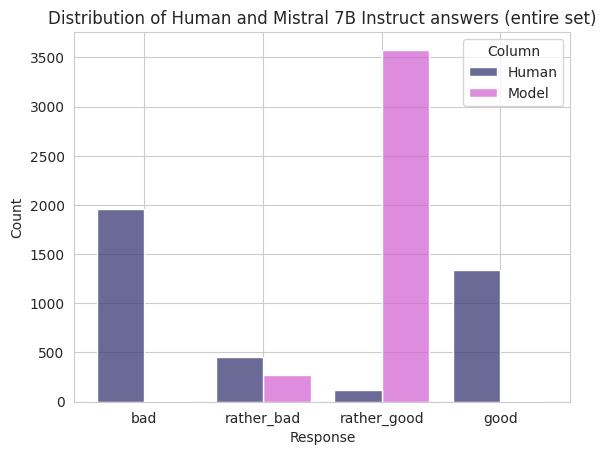

In [204]:
res_df = pd.DataFrame(data={
    "Human": data_P5_results["true"],
    "Model": data_P5_results["short_answer"]
})

df_long = res_df.melt(var_name='Column', value_name='Response')

palette_colors = {"Human": "#3A3875", "Model": "#D366D3"}

sns.histplot(data=df_long, x='Response', hue='Column', multiple='dodge', shrink=0.8, palette=palette_colors)

plt.title('Distribution of Human and Mistral 7B Instruct answers (entire set)')
plt.show()

In [203]:
print("Accuracy:", round(accuracy_score(res_df["Human"], res_df["Model"]), 4))
print("F1-score (weighted):", round(f1_score(res_df["Human"], res_df["Model"], average="weighted"), 4))

Accuracy: 0.0422
F1-score (weighted): 0.0191
